In [1]:

!pip install optree

Found 8192 images belonging to 5 classes.
Found 2046 images belonging to 5 classes.
✅ BATCH SHAPE: (32, 224, 224, 3) (32, 5)


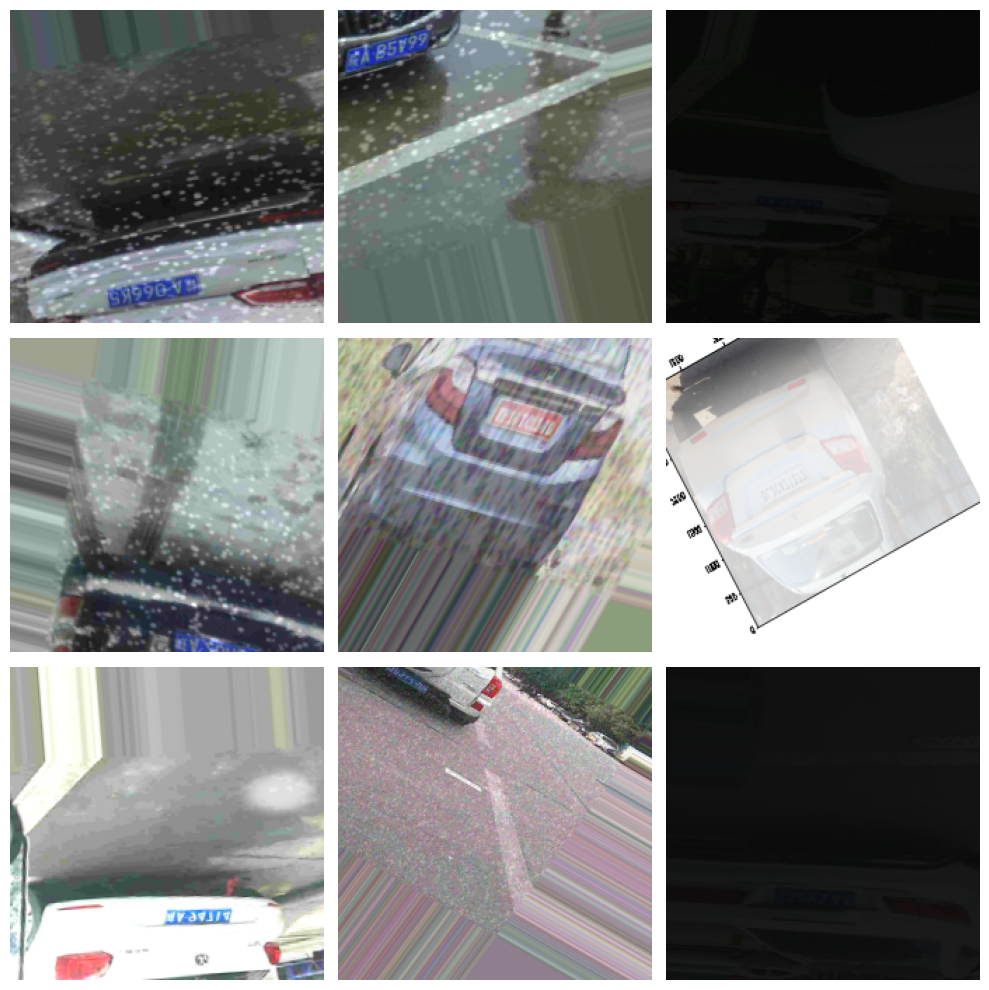

✅ TRAINING SAMPLES: 8192
✅ VALIDATION SAMPLES: 2046
✅ TRAINING CLASSES: {'foggy': 0, 'low_light': 1, 'rainy': 2, 'sn': 3, 'sunny': 4}
✅ VALIDATION CLASSES: {'foggy': 0, 'low_light': 1, 'rainy': 2, 'sn': 3, 'sunny': 4}


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# ✅ CLEAR SESSION TO AVOID tf.function ISSUES
tf.keras.backend.clear_session()

# ✅ PARAMETERS
batch_size = 32
img_height, img_width = 224, 224

# ✅ IMAGE DATA GENERATOR WITH AUGMENTATION
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# ✅ TRAINING GENERATOR
train_gen = datagen.flow_from_directory(
    directory='D:/fypfinal/yolo_dataset/images',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42  # Add seed for reproducibility
)

# ✅ VALIDATION GENERATOR
val_gen = datagen.flow_from_directory(
    directory='D:/fypfinal/yolo_dataset/images',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# ✅ CHECK THAT BATCHES ARE WORKING
x_batch, y_batch = next(train_gen)
print("✅ BATCH SHAPE:", x_batch.shape, y_batch.shape)

# ✅ DISPLAY FIRST 9 IMAGES
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    axes[i//3, i%3].imshow(x_batch[i])
    axes[i//3, i%3].axis('off')
plt.tight_layout()
plt.show()

# ✅ CALLBACKS
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)


# ✅ CLASS INFO
print("✅ TRAINING SAMPLES:", train_gen.samples)
print("✅ VALIDATION SAMPLES:", val_gen.samples)
print("✅ TRAINING CLASSES:", train_gen.class_indices)
print("✅ VALIDATION CLASSES:", val_gen.class_indices)


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# ✅ LOAD BASE MODEL WITHOUT TOP
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base

# ✅ BUILD MODEL
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 classes
])

# ✅ COMPILE
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# ✅ TRAIN
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

# ✅ SAVE FINAL MODEL
model.save('saved_model_mobilenettt.keras')

E:\jupyter\jupyternotebook\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.8177 - loss: 0.5010 - val_accuracy: 0.9736 - val_loss: 0.1002
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.9821 - loss: 0.0603 - val_accuracy: 0.9751 - val_loss: 0.0693
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.9912 - loss: 0.0371 - val_accuracy: 0.9736 - val_loss: 0.0707
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.9911 - loss: 0.0302 - val_accuracy: 0.9883 - val_loss: 0.0373
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - accuracy: 0.9950 - loss: 0.0218 - val_accuracy: 0.9844 - val_loss: 0.0469
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.9939 - loss: 0.0222 - val_accuracy: 0.9858 - val_loss: 0.0475
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.9939 - loss: 0.0179 - val_accuracy: 0.9844 - val_loss: 0.0422
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - accuracy: 0.9934 - loss: 0.0183 - val_accu

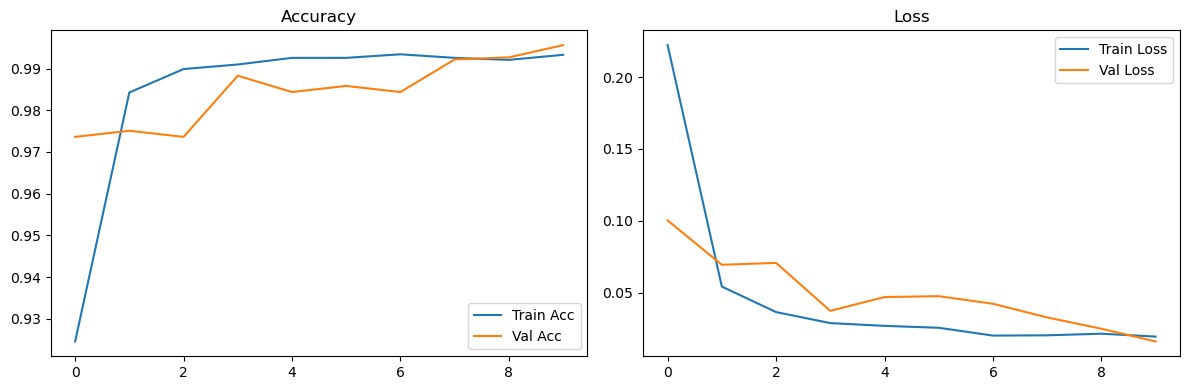

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()
